# Seasonality in Transmission

Let's look at seasonal transmission in the SIR model.

In [2]:
import numpy as np

from laser.core.utils import grid
from laser.core import PropertySet
import laser.core.distributions as dists

from laser.generic import Model
from laser.generic import SIR
from laser.generic.vitaldynamics import ConstantPopVitalDynamics
from laser.generic.newutils import ValuesMap


In [3]:
NTICKS = 365 * 10
infectious_duration_mean = 14.0
infectious_duration_scale = 1.5
R0 = 15.0
beta = R0 / infectious_duration_mean
CBR = 33
mu = (1 + (CBR / 1000))**(1/365) - 1
    
scenario = grid(1, 1, population_fn=lambda row, col: 1_000_000)
scenario["S"] = np.round(scenario.population / R0).astype(np.int32)
scenario["I"] = (scenario.population * mu * (R0 - 1) / beta).astype(np.int32)
scenario["R"] = scenario.population - (scenario.S + scenario.I)

parameters = PropertySet({"nticks": NTICKS, "beta": beta})

no_seasonality = Model(scenario, parameters, birthrates=None)

infdurdist = dists.normal(loc=infectious_duration_mean, scale=infectious_duration_scale)

no_seasonality.components = [
    SIR.Susceptible(no_seasonality),
    SIR.Infectious(no_seasonality, infdurdist, infdurmin=1.0),
    SIR.Recovered(no_seasonality),
    SIR.Transmission(no_seasonality, infdurdist, infdurmin=1.0, seasonality=None),
    ConstantPopVitalDynamics(no_seasonality, recycle_rates=ValuesMap.from_scalar(CBR, 1, NTICKS)),
]

no_seasonality.run()

1,000,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:03<00:00, 1103.56it/s]


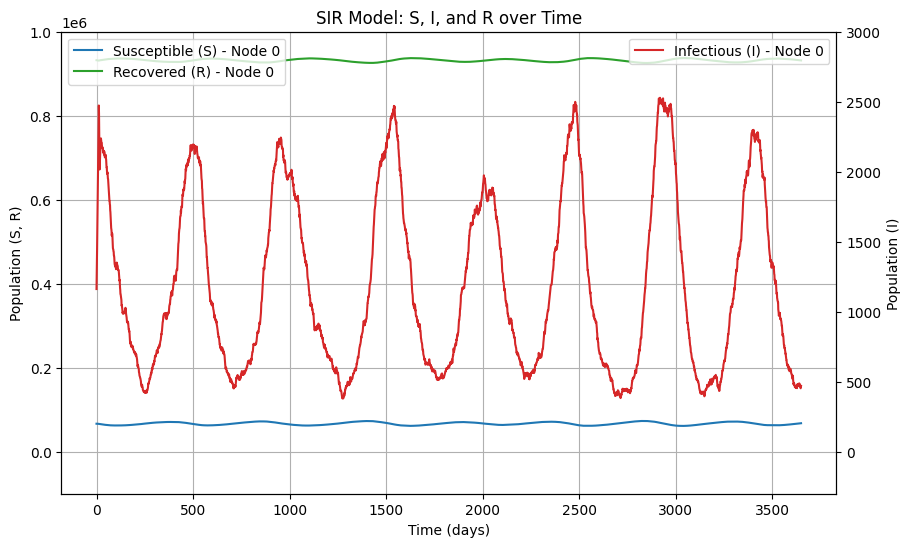

In [4]:
import matplotlib.pyplot as plt

def plot_model(model):
    history = model.nodes

    _fig, ax1 = plt.subplots(figsize=(10, 6))

    styles = ['-', '--', '-.', ':']

    # Primary axis: S and R
    for node in range(model.nodes.count):
        ax1.plot(history.S[:, node], label=f'Susceptible (S) - Node {node}', color='tab:blue', linestyle=styles[node % len(styles)])
        ax1.plot(history.R[:, node], label=f'Recovered (R) - Node {node}', color='tab:green', linestyle=styles[node % len(styles)])
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Population (S, R)')

    N = (history.S + history.I + history.R)
    ax1.set_ylim(-N.max() / 10, N.max())

    ax1.legend(loc='upper left')
    ax1.grid()

    # Secondary axis: I
    ax2 = ax1.twinx()
    for node in range(model.nodes.count):
        ax2.plot(history.I[:, node], label=f'Infectious (I) - Node {node}', color='tab:red', linestyle=styles[node % len(styles)])
    ax2.set_ylabel('Population (I)')

    maximum = ((int(history.I.max()) // 500) + 1) * 500
    ax2.set_ylim(-maximum / 10, maximum)

    ax2.legend(loc='upper right')

    plt.title('SIR Model: S, I, and R over Time')
    plt.show()

plot_model(no_seasonality)

## Seasonality

Let's introduce some seasonal forcing on a yearly basis: $1 + 0.2 * sin((t - 214)/365)$


In [5]:
sinusoidal = Model(scenario, parameters, birthrates=None)

seasonality = ValuesMap.from_timeseries(
    1.0 + 0.2 * np.sin((np.arange(NTICKS) - 214) * (2 * np.pi / 365)),
    sinusoidal.nodes.count,
)

sinusoidal.components = [
    SIR.Susceptible(sinusoidal),
    SIR.Infectious(sinusoidal, infdurdist, infdurmin=1.0),
    SIR.Recovered(sinusoidal),
    SIR.Transmission(sinusoidal, infdurdist, infdurmin=1.0, seasonality=seasonality),
    ConstantPopVitalDynamics(sinusoidal, recycle_rates=ValuesMap.from_scalar(CBR, 1, NTICKS)),
]

sinusoidal.run()


1,000,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:03<00:00, 1186.45it/s]


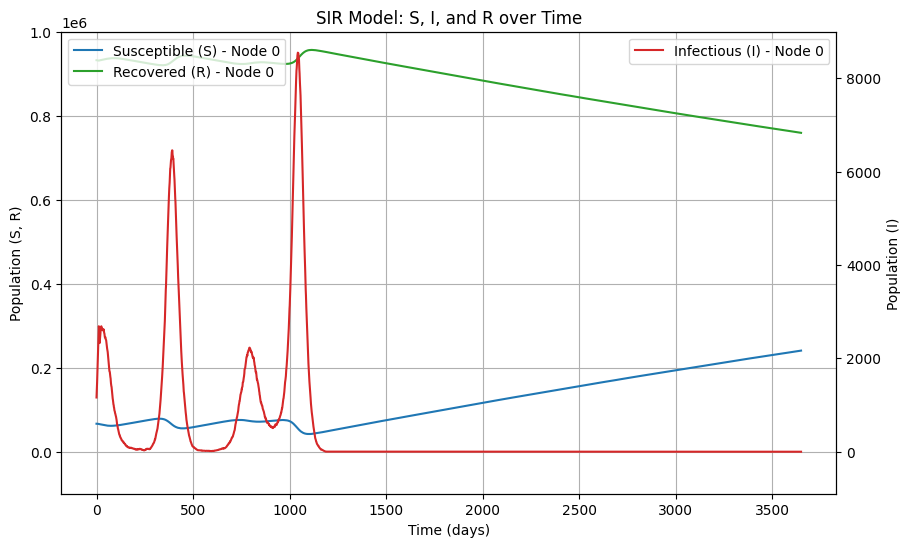

In [6]:
plot_model(sinusoidal)


## Importation

Looks like we are going to need some periodic importation to keep from seeing extinction.

In [7]:
from laser.generic import State

class Importation:
    def __init__(self, model, period, cases, infdurdist, infdurmin=1.0):
        self.model = model
        self.period = period
        self.cases = cases
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin

        return
    
    def step(self, tick):
        if tick % self.period != 0:
            return

        susceptible_indices = np.nonzero(self.model.people.state == State.SUSCEPTIBLE.value)[0]
        imports = np.random.choice(susceptible_indices, size=self.cases, replace=False)
        self.model.people.state[imports] = State.INFECTIOUS.value
        self.model.people.itimer[imports] = np.maximum(np.round(dists.sample_floats(self.infdurdist, np.zeros_like(imports, dtype=np.float32), 0, 0)), self.infdurmin)

        # print(f"Importing {len(imports):3} cases at tick {tick:4}")

        self.model.nodes.S[tick+1] -= len(imports)
        self.model.nodes.I[tick+1] += len(imports)

        return

In [8]:
with_importation = Model(scenario, parameters, birthrates=None)

with_importation.components = [
    SIR.Susceptible(with_importation),
    SIR.Infectious(with_importation, infdurdist, infdurmin=1.0),
    SIR.Recovered(with_importation),
    SIR.Transmission(with_importation, infdurdist, infdurmin=1.0, seasonality=seasonality),
    ConstantPopVitalDynamics(with_importation, recycle_rates=ValuesMap.from_scalar(CBR, 1, NTICKS)),
    Importation(with_importation, period=30, cases=3, infdurdist=infdurdist, infdurmin=1.0),
]

with_importation.run()

1,000,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:03<00:00, 1191.51it/s]


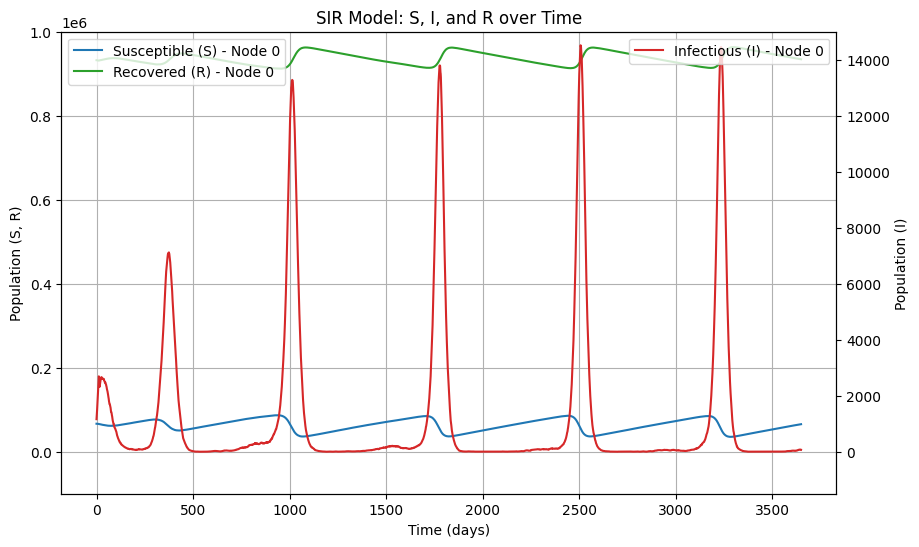

In [9]:
plot_model(with_importation)


So, a few cases coming in every 30 days along with seasonal forcing gives us a very nice periodic outbreak every two years.

It might be interesting to see how seasonal forcing interacts with critical community size for endemicity. We will leave that as an exercise for the reader.


In [10]:
## Coupled locations with out of phase seasonality.

two_node_scenario = grid(1, 2, population_fn=lambda row, col: 500_000)
two_node_scenario["S"] = np.round(two_node_scenario.population / R0).astype(np.int32)
two_node_scenario["I"] = (two_node_scenario.population * mu * (R0 - 1) / beta).astype(np.int32)
two_node_scenario["R"] = two_node_scenario.population - (two_node_scenario.S + two_node_scenario.I)

two_node_model = Model(two_node_scenario, parameters, birthrates=None)

# two_node_seasonality = np.zeros((NTICKS, two_node_model.nodes.count), np.float32)
# two_node_seasonality[:, 0] = 1.0 + 0.2 * np.sin((np.arange(NTICKS) - 214) * (2 * np.pi / 365))
# two_node_seasonality[:, 1] = 1.0 + 0.2 * np.cos((np.arange(NTICKS) - 214) * (2 * np.pi / 365))
two_node_seasonality = ValuesMap.from_timeseries(
    1.0 + 0.2 * np.sin((np.arange(NTICKS) - 214) * (2 * np.pi / 365)),
    two_node_model.nodes.count,
)

two_node_model.components = [
    SIR.Susceptible(two_node_model),
    SIR.Infectious(two_node_model, infdurdist, infdurmin=1.0),
    SIR.Recovered(two_node_model),
    SIR.Transmission(two_node_model, infdurdist, infdurmin=1.0, seasonality=two_node_seasonality),
    ConstantPopVitalDynamics(two_node_model, recycle_rates=ValuesMap.from_scalar(CBR, 1, NTICKS)),
    Importation(two_node_model, period=365, cases=3, infdurdist=infdurdist, infdurmin=1.0),
]

two_node_model.network /= 500.0  # Reduce coupling for clearer dynamics.

two_node_model.run()


1,000,000 agents in 2 node(s): 100%|██████████| 3650/3650 [00:02<00:00, 1318.08it/s]


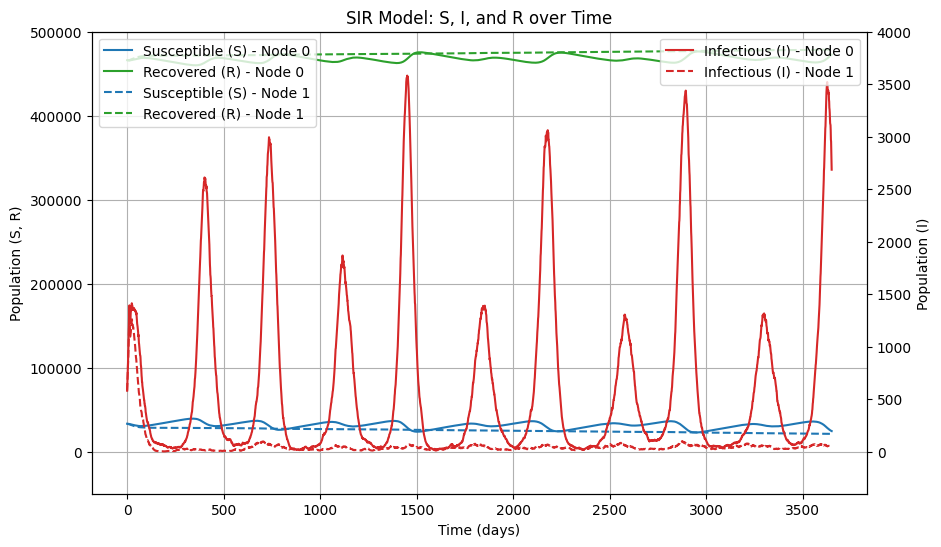

In [11]:
plot_model(two_node_model)


In [12]:
two_node_model.network


array([[0.       , 0.0001875],
       [0.0001875, 0.       ]], dtype=float32)

## Test the SI Model

Let's a) make sure the TransmissionSIX component's seasonality is working and b) let's use a crazy "seasonality" to make the effect obvious.


SI model without seasonality: 100%|██████████| 730/730 [00:00<00:00, 2668.67it/s]


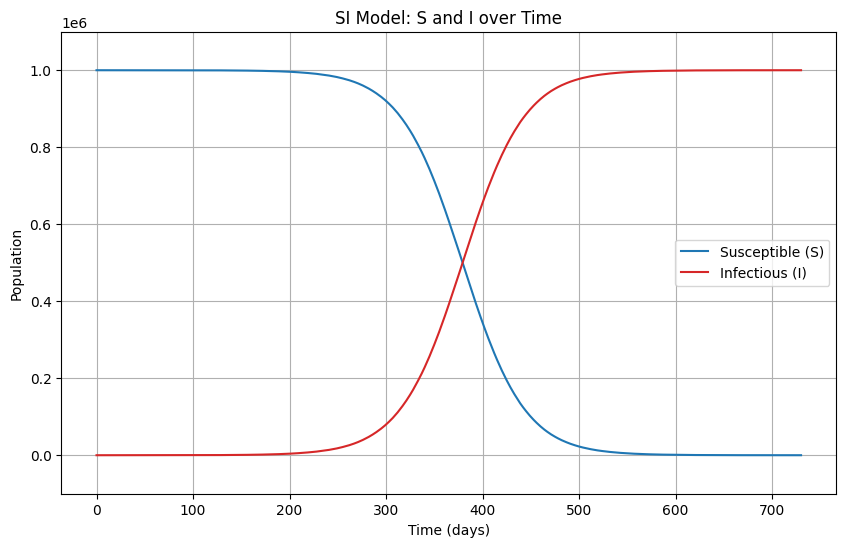

In [22]:
from laser.generic import SI

scenario = grid(1, 1, population_fn=lambda row, col: 1_000_000)
scenario["S"] = scenario.population - 10
scenario["I"] = 10

# 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625
parameters = PropertySet({"nticks": 730, "beta": 0.03125})

si_wout_seasonality = Model(scenario, parameters, birthrates=None)
si_wout_seasonality.components = [
    SI.Susceptible(si_wout_seasonality),
    SI.Infectious(si_wout_seasonality),
    SI.Transmission(si_wout_seasonality, seasonality=None),
]

si_wout_seasonality.run("SI model without seasonality")

def plot_si_model(model):
    history = model.nodes

    plt.figure(figsize=(10, 6))
    plt.plot(history.S[:, 0], label='Susceptible (S)', color='tab:blue')
    plt.plot(history.I[:, 0], label='Infectious (I)', color='tab:red')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title('SI Model: S and I over Time')
    plt.ylim(-model.scenario.population[0] / 10, model.scenario.population[0] * 1.1)
    plt.legend()
    plt.grid()
    plt.show()

    return

plot_si_model(si_wout_seasonality)


Now, let's set up "seasonality".

SI model with seasonality: 100%|██████████| 730/730 [00:00<00:00, 1899.61it/s]


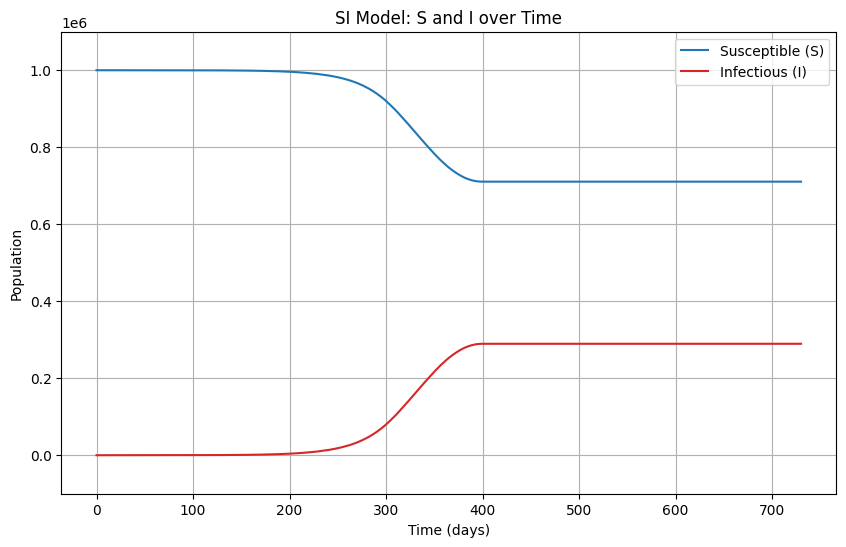

In [27]:
si_with_seasonality = Model(scenario, parameters, birthrates=None)

seasonality = np.ones((parameters.nticks, si_with_seasonality.nodes.count), np.float32)
# Phase out transmission between days 300 and 400
seasonality[300:400,:] = np.linspace(1.0, 0.0, 100)[:, None]
seasonality[400:,:] = 0.0
seasonality = ValuesMap.from_array(seasonality)

si_with_seasonality.components = [
    SI.Susceptible(si_with_seasonality),
    SI.Infectious(si_with_seasonality),
    SI.Transmission(si_with_seasonality, seasonality=seasonality),
]

si_with_seasonality.run("SI model with seasonality")
plot_si_model(si_with_seasonality)
